In [7]:
import numpy as np
import scipy.linalg as scila
import TransportMaps.Distributions as DIST
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
%%latex
1D distribution  
 
$\pi(x) = \frac{1}{\sqrt{2\pi \sigma^2}} exp(\frac{(x - \mu)^2}{2\sigma^2})$
 
$log \pi(x) = - \frac{(x - \mu)^2}{ 2  \sigma^2} - \frac{1}{2} log(2 \pi \sigma^2)$

$\nabla log \pi(x) = - \frac{(x - \mu)}{  \sigma^2}$

$\nabla^2 log \pi(x) = - \frac{1}{  \sigma^2}$



<IPython.core.display.Latex object>

In [19]:
# 1D gaussian
class Gaussian1D(DIST.Distribution):
    def __init__(self,mu,sigma2):
        self.mu = mu
        self.sigma = np.sqrt(sigma2)
        super(Gaussian1D,self).__init__(1)
    def log_pdf(self,x,*args,**kwargs):
        out = -(x - self.mu)**2/(2*self.sigma**2) - .5 * np.log(2*np.pi*self.sigma**2)
        return out[:,0]
    def grad_x_log_pdf(self,x,*args,**kwargs):
        out =  -(x - self.mu)/self.sigma**2
        return out
    def hess_x_log_pdf(self,x,*args,**kwargs):
        out = -np.ones(x.shape[0])/self.sigma**2
        return out[:,np.newaxis,np.newaxis]
        

mu = 2.
sigma2 = 0.5
nupi = Gaussian1D(mu, sigma2)
x = np.linspace(-5,5,100)[:,np.newaxis]  # array (m,1)
plt.figure();
plt.plot(x, nupi.pdf(x));

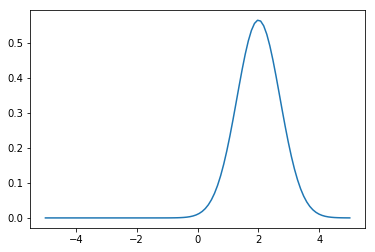

In [21]:
mu = 2. 
sigma2 = 0.5
nupi = Gaussian1D(mu, sigma2) 
x = np.linspace(-5,5,100)[:,np.newaxis] # array (m,1) 
plt.figure(); plt.plot(x, nupi.pdf(x));

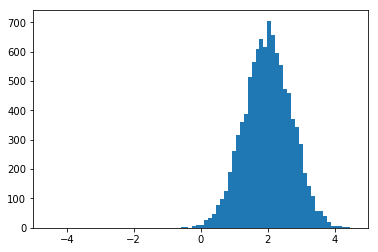

In [23]:
class Gaussian1D_MC(DIST.Distribution):
    def __init__(self,mu,sigma2):
        self.mu = mu
        self.sigma = np.sqrt(sigma2)
        super(Gaussian1D_MC,self).__init__(1)
    def quadrature(self,qtype,qnum,*args,**kwargs):
        if qtype == 0:
            z = np.random.randn(qnum)
            x = self.mu + self.sigma*z
        return x

nupi = Gaussian1D_MC(mu,sigma2)
smp = nupi.quadrature(0, 10000) # Equivalent to: nupi.rvs(10000)
plt.figure(); plt.xlim(-5,5)
plt.hist(smp,bins=50);

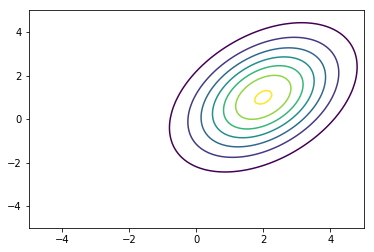

In [26]:
# 2D Distribution
class Gaussian2D(DIST.Distribution):
    def __init__(self,mu,sigma):
        super(Gaussian2D,self).__init__(2)
        self.mu = mu
        self.sigma = sigma
        chol = scila.cho_factor(self.sigma,True)
        self.det_sigma = np.prod(np.diag(chol[0]))**2
        self.log_det_sigma = 2 * np.sum(np.log(np.diag(chol[0])))
        self.inv_sigma = scila.cho_solve(chol,np.eye(self.dim))
    def log_pdf(self, x, *args, **kwargs):
        # x.shape is (m,2)
        # Returns array of (m,) elements
        b = x - self.mu
        sol = np.dot( self.inv_sigma, b.T ).T
        out = - .5 * np.einsum('...i,...i->...', b, sol) \
              - self.dim * .5 * np.log(2.*np.pi) \
              - .5 * self.log_det_sigma
        return out.flatten()
    def grad_x_log_pdf(self, x, *args, **kwargs):
        # x.shape is (m,2)
        # Returns array of (m,2) elements
        b = x - self.mu
        return - np.dot( self.inv_sigma, b.T ).T
    def hess_x_log_pdf(self, x, *args, **kwargs):
        # x.shape is (m,2)
        # Returns array of (m,2,2) elements
        return - np.ones(x.shape[0])[:,nax,nax] * self.inv_sigma[nax,:,:]



mu = np.array([2., 1.])
sigma = np.array([[2., 1.],
                  [1., 3.]])
nupi = Gaussian2D(mu, sigma)
x = np.linspace(-5,5,100)
X,Y = np.meshgrid(x,x)
xx = np.vstack((X.flatten(),Y.flatten())).T # xx.shape is (100^2,2)
pdf = nupi.pdf(xx).reshape(X.shape)
plt.figure()
plt.contour(X,Y,pdf)
        

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]]),
 array([-5.56641385, -5.26174156, -4.95706927, -4.65239698, -4.34772469,
        -4.0430524 , -3.73838011, -3.43370782, -3.12903553, -2.82436324,
        -2.51969095, -2.21501866, -1.91034637, -1.60567408, -1.30100179,
        -0.9963295 , -0.69165721, -0.38698492, -0.08231263,  0.22235966,
         0.52703195,  0.83170424,  1.13637653,  1.44104882,  1.74572111,
         2.0503934 ,  2.35506569,  2.65973798,  2.96441027,  3.26908256,
         3.57375485,  3.87842714,  4.18309943,  4.48777172,  4.79244401,
         5.09711629,  5.40178858,  5.70646087,  6.01113316,  6.31580545,
         6.62047774,  6.92515003,  7.22982232,  7.53449461,  7.8391669 ,
         8.14383919,  8.44851148,  8.75318377,  9.0578560

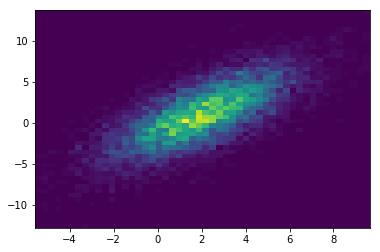

In [29]:
'''
quadrature rules(Monte-carlo)
'''
class Gaussian2D_MC(DIST.Distribution):
    def __init__(self, mu, sigma):
        super(Gaussian2D_MC, self).__init__(2) # This sets self.dim=2
        self.mu = mu
        self.sigma = sigma
        chol = scila.cho_factor(self.sigma, True) # True: lower triangular
        self.sampling_mat = np.tril(chol[0])
    def quadrature(self, qtype, qnum, *args, **kwargs):
        if qtype == 0: # The type 0 is reserved for MC sampling
            z = np.random.randn(self.dim * qnum).reshape((qnum,self.dim))
            x = self.mu + np.dot( self.sigma, z.T ).T
        return x

nupi = Gaussian2D_MC(mu,sigma)
smp = nupi.quadrature(0,10000)
plt.figure()
plt.hist2d(smp[:,0],smp[:,1],bins = 50)

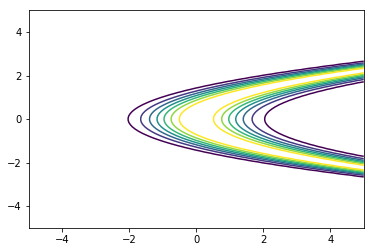

In [31]:
# conditional distributions
class SquaredConditionallyGaussian(DIST.ConditionalDistribution):
    def __init__(self,sigma2):
        super(SquaredConditionallyGaussian,self).__init__(1,1)
        self.sigma = np.sqrt(sigma2)
    def log_pdf(self, x, y, *args, **kwargs):
        # x.shape is (m,1)
        # y.shape is (m,1)
        # Returns array of (m,) elements
        out = -(x-y**2)**2/(2*self.sigma**2) - .5 * np.log(2*np.pi*self.sigma**2)
        return out[:,0]
    def grad_x_log_pdf(self, x, y, *args, **kwargs):
        # x.shape is (m,1)
        # y.shape is (m,1)
        # Returns array of (m,2) elements
        out = np.zeros((x.shape[0],2))
        out[:,0] = -(x-y**2)/self.sigma**2
        out[:,1] = -(x-y**2)*2*y/self.sigma**2
        return out
    def hess_x_log_pdf(self, x, y, *args, **kwargs):
        # x.shape is (m,1)
        # y.shape is (m,1)
        # Returns array of (m,2,2) elements
        out = np.zeros((x.shape[0],2,2))
        out[:,0,0] = - np.ones(x.shape[0]) / self.sigma**2
        out[:,1,1] = 2/self.sigma**2 * (2*y**2 - (x-y**2))
        out[:,0,1] = 2*y/self.sigma**2
        out[:,1,0] = out[:,0,1]
        return out
nupi = SquaredConditionallyGaussian(sigma2 = 1)
pdf = nupi.pdf(xx[:,[0]],xx[:,[1]]).reshape(X.shape)
plt.figure
plt.contour(X,Y,pdf)